Ref: 
https://www.tensorflow.org/guide/keras/custom_layers_and_models
https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

https://tf.wiki/zh_hant/preface.html

https://github.com/maziarraissi/PINNs

https://www.google.com/search?q=advection+equation+1d+example&sxsrf=ALeKk004lhshcbdtG-6AuVFvY3ho_AK6kw:1607219788227&source=lnms&tbm=isch&sa=X&ved=2ahUKEwibkLakoLjtAhWNyIsBHQE3CTQQ_AUoAXoECAUQAw&biw=1055&bih=833

## The PDE example

The PDE equation is:

$$\frac{\partial \phi}{\partial t}=-u\frac{\partial \phi}{\partial x}$$

With the initial value:
$$\phi_0 = \phi(x,0)$$

In [261]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

print(tf.__version__)

2.3.1


# 1. Build model

## [Loss function](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses)

In [262]:
class PDE_Loss(tf.keras.losses.Loss):
    def __init__(self, phi_init, u, regularization_factor=0.1, name="PDE_Loss"):
        super().__init__(name=name)
        self.phi_init = phi_init
        self.u = u
    
    def call(self, inputs, phi):
        
        gradient = tf.gradients(phi, inputs)[0]
        phi_t, phi_x = tf.unstack(gradient,axis=1)

        phi_t = tf.reshape(phi_t, [phi_t.shape[0],1])
        phi_x = tf.reshape(phi_x, [phi_x.shape[0],1])
        
        governing_Eq = phi_t+self.u+phi_x
        
        init_size = self.phi_init.shape[0]

        number_of_time_step = governing_Eq.shape[0] / init_size
        
        loss = tf.reduce_mean(tf.square(phi[:init_size]-self.phi_init)) 

        for one_time_step in range(int(number_of_time_step)):
                    
            loss += tf.reduce_mean(tf.square(
                # governing_Eq in loss   
                governing_Eq[one_time_step*init_size:(one_time_step+1)*init_size] +
                 # bc in loss   
                phi[one_time_step*init_size][0]-1.0 + 
                phi[(one_time_step+1)*init_size-1][0]-1.0
            ))
            

        return loss

## [Metric](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_metrics)

In [263]:
class PDE_Metric(tf.keras.metrics.Metric):
    def __init__(self, name="PDE_Metric", **kwargs):
        super().__init__(name=name, **kwargs)
         # define metric state variable here
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # update metric state variable here
        pass
    
    def result(self):
        # update metric result here
        return 0.0

    def reset_states(self):
        # reset metric state here
        pass


## [Model](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit)

In [264]:
class solve_PDE_Model(tf.keras.Model):
    def __init__(self):
        super().__init__() 

        self.layer1 = tf.keras.layers.Dense(units=15, activation=tf.nn.sigmoid, name='layer1')
        self.layer2 = tf.keras.layers.Dense(units=15, activation=tf.nn.sigmoid, name='layer2')
        self.layer3 = tf.keras.layers.Dense(units=1, name='output')
        
            
    def call(self, inputs):
        outputs = self.layer1(inputs)
        outputs = self.layer2(outputs)
        outputs = self.layer3(outputs)
        return outputs
    
    def train_step(self, inputs):
        # handle inputs depend on your model and on what you pass to `fit()`.

        with tf.GradientTape() as tape:
            phi = self(inputs, training=True)

            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(inputs, phi)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics (includes the metric that tracks the loss)
        _ = tf.zeros(shape=(2))
        self.compiled_metrics.update_state(_, _)
    
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    # issue:
    # https://github.com/tensorflow/tensorflow/issues/25036
    # https://stackoverflow.com/questions/55235212/model-summary-cant-print-output-shape-while-using-subclass-model/55236388#55236388
    def summary(self):
        x = tf.keras.Input(shape=(2))
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

# 2. Run model

## Create input

### Setting simulation domain

In [265]:
lx = 2
nx = 20
dx = lx / (nx-1)

lt = 0.5
nt = 25

u = 1      #assume wavespeed of u = 1

In [266]:
phi_init = np.ones(nx)
phi_init[int(.5 / dx):int(1 / dx + 1)] = 2
phi_init = phi_init.reshape(phi_init.shape[0],-1)
phi_init = tf.constant(phi_init, dtype=tf.float32)
print (phi_init)

tf.Tensor(
[[1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(20, 1), dtype=float32)


In [267]:
x_all = np.linspace(0, lx, nx)
x_all = tf.constant(x_all, dtype=tf.float32)

t_all = np.linspace(0, lt, nt)
t_all = tf.constant(t_all, dtype=tf.float32)

def combine(x, y):
  xx, yy = tf.meshgrid(x, y, indexing='ij')
  return tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)

inputs_all = combine(t_all,x_all)

print(inputs_all.shape)

# print(inputs.numpy()[:10])

(500, 2)


### Instantiate model ()

In [268]:
model = solve_PDE_Model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss=PDE_Loss(phi_init,u),
    metrics=[PDE_Metric(),]
)

model.summary()

Model: "functional_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 15)                45        
_________________________________________________________________
layer2 (Dense)               (None, 15)                240       
_________________________________________________________________
output (Dense)               (None, 1)                 16        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


## Run model

In [269]:
model.fit(inputs_all,batch_size=inputs_all.shape[0],  shuffle=False, epochs=50000, verbose =0)

In [270]:
result = model(inputs_all)

# Validate Model

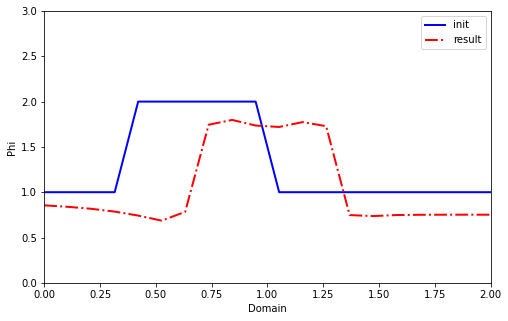

In [274]:
%matplotlib inline

# create a figure and axes
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(1,1,1)   

# set up the subplots as needed
ax1.set_xlim((0, 2))            
ax1.set_ylim((0, 3))
ax1.set_xlabel('Domain')
ax1.set_ylabel('Phi')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
n=15
txt_title = ax1.set_title('')
line1, = ax1.plot(x_all, phi_init, 'b', lw=2)     # ax.plot returns a list of 2D line objects
line2, = ax1.plot(x_all, result[n*nx:(n+1)*nx], 'r-.', lw=2)     # ax.plot returns a list of 2D line objects
ax1.legend(['init','result']);